#    Seasonal Autoregressive Integrated Moving Averages

In this SARIMA project the data i have used is Monthly Mean CO2 Levels (ppm) over Mouna Loa, Hawaii. Here ARIMA accepts the parameters  (p,d,q) whereas  SARIMA accepts an additional set of parameters  (P,D,Q)m  that specifically describe the seasonal components of the model. Here  𝑃 ,  𝐷  and  𝑄  represent the seasonal regression, differencing and moving average coefficients, and  m  represents the number of data points (rows) in each seasonal cycle.

The dataset contains 5 columns are- 1.Year, 2.Month, 3.Decimal_date, 4.Average, 5.interpolated and 729 rows.

# Importing standard Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Specific Forecasting Tools

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

In [4]:
# Ignore harmless warnings

import warnings
warnings.filterwarnings("ignore")

# Loading dataset

Dataset source 

github:https://github.com/datasets/co2-ppm/blob/master/data/co2-mm-mlo.csv 


Kaggle:https://www.kaggle.com/rahulshriwastav/time-series-analysis

In [5]:
df = pd.read_csv(r'co2_mm_mlo.csv')

In [6]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


# Inspecting Data and creating DatetimeIndex

In [7]:
df['Date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

In [8]:
df.head()

,year,month,decimal_date,average,interpolated,Date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          729 non-null    int64         
 1   month         729 non-null    int64         
 2   decimal_date  729 non-null    float64       
 3   average       722 non-null    float64       
 4   interpolated  729 non-null    float64       
 5   Date          729 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.3 KB


Reassigning Date as index column and changing frequency to MS as the data is Monthly Starts

In [10]:
df = df.set_index('Date')

In [11]:
df.head()

,year,month,decimal_date,average,interpolated
Date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [12]:
df.index.freq = 'MS'

# Plotting Source Data

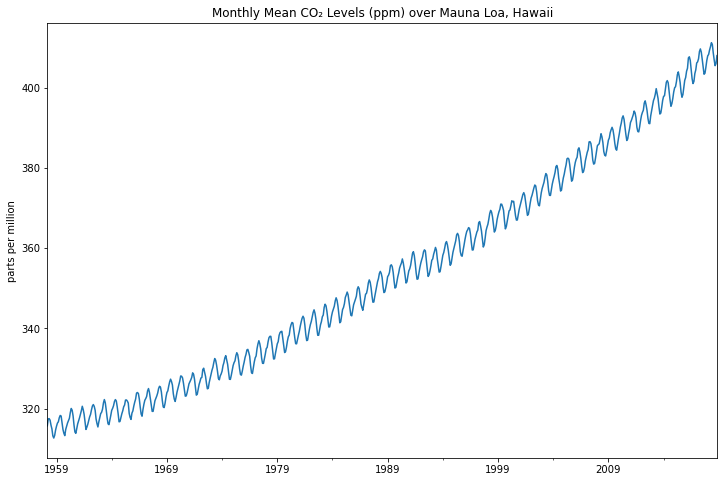

In [13]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''
sourcedata = df['interpolated'].plot(figsize=(12,8),title=title)
sourcedata.set(xlabel=xlabel,ylabel=ylabel);

# Running ETS Decomposition

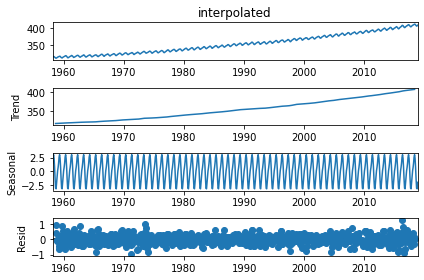

In [14]:
result = seasonal_decompose(df['interpolated'],model='add')
result.plot();

We can clearly see that there is seasonality in the data

# Running pmdarima.auto_arima to obtain best recommended orders

This may take awhile as there are a lot more combinations to evaluate.

In [15]:
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.406
Date:                            Thu, 18 Mar 2021   AIC                            424.812
Time:                                    10:22:14   BIC                            447.763
Sample:                                         0   HQIC                           433.668
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2290      0.075      3.057      0.002       0.082       0.376
ma.L1         -0.5759      0.064     -8.940      0.000      -0.702      -0.450
ar.S.L12       0.9996      0.000   3059.292      0.000       0.999       1.000
ma.S.L12      -0.8652      0.021    -40.524      0.000      -0.907      -0.823
sigma2         0.0957      0.005     20.586      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       48.90   Jarque-Bera (JB):                 4.77
Prob(Q):                              0.16   Prob(JB):                         0.09
Heteroskedasticity (H):               1.12   Skew:                            -0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here ARIMA Order of (1,1,1) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(1,1,1)(1,0,1,12) model, evaluate it, then produce a forecast of future values.

# Split the data into train/test sets

In [16]:
len(df)

729

In [17]:
train = df.iloc[:717]
test = df.iloc[717:]

In [18]:
print(len(train))
print(len(test))

717
12


# Fitting a SARIMA(1,1,1)(1,0,1,12) Model

In [19]:
model = SARIMAX(df['interpolated'],order=(1,1,1),seasonal_order=(1,0,1,12))

In [20]:
result = model.fit()

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.406
Date:                            Thu, 18 Mar 2021   AIC                            424.812
Time:                                    10:22:19   BIC                            447.763
Sample:                                03-01-1958   HQIC                           433.668
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2290      0.075      3.057      0.002       0.082       0.376
ma.L1         -0.5759      0.064     -8.940      0.000      -0.702      -0.450
ar.S.L12       0.9996      0.000   3059.292      0.000       0.999       1.000
ma.S.L12      -0.8652      0.021    -40.524      0.000      -0.907      -0.823
sigma2         0.0957      0.005     20.586      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       48.90   Jarque-Bera (JB):                 4.77
Prob(Q):                              0.16   Prob(JB):                         0.09
Heteroskedasticity (H):               1.12   Skew:                            -0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Plot predictions against known values

In [22]:
start = len(train)
end = len(train)+len(test)-1

In [23]:
prediction = result.predict(start,end,typ='levels')

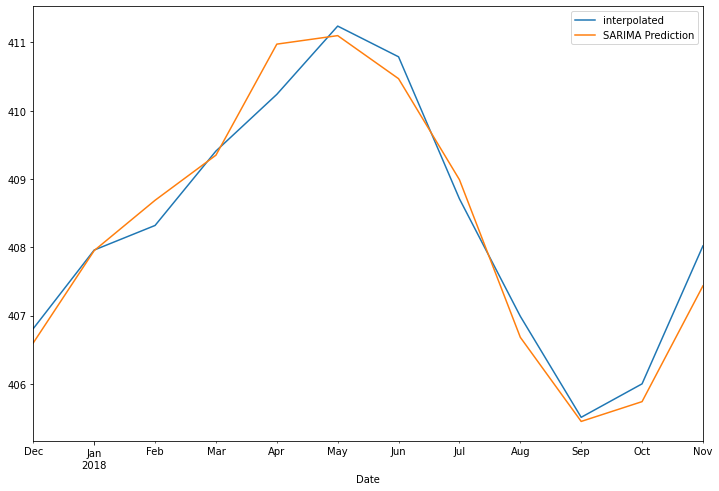

In [24]:
test['interpolated'].plot(figsize=(12,8),legend=True)
prediction.plot(legend=True, label='SARIMA Prediction')

# Evaluate the Model

In [25]:
from statsmodels.tools.eval_measures import rmse

In [26]:
error = rmse(test['interpolated'],prediction)

In [27]:
print('SARIMA(1,1,1)(1,0,1,12) rmse error is ', error)

SARIMA(1,1,1)(1,0,1,12) rmse error is  0.34577368873690395


In [28]:
test['interpolated'].mean()

408.3333333333333

# Retrain the model on the full data, and forecast the future

In [29]:
model = SARIMAX(df['interpolated'],order=(1,1,1),seasonal_order=(1,0,1,12))

In [30]:
result = model.fit()

In [31]:
forecast = result.predict(len(df),len(df)+24,typ='levels')

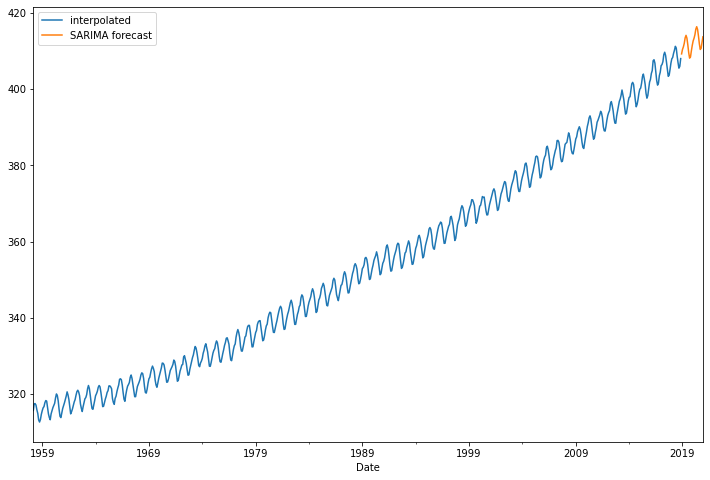

In [32]:
df['interpolated'].plot(figsize=(12,8),legend=True)
forecast.plot(legend=True,label='SARIMA forecast')